In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, pathlib 
ROOT_DIR = os.path.join(str(pathlib.Path.home()), "MonoGS")
print(f"Changing working directory to {ROOT_DIR}")
os.chdir(ROOT_DIR)

Changing working directory to /home/ubuntu/MonoGS


In [3]:
from munch import munchify
from utils.config_utils import load_config
from utils.dataset import load_dataset

pc_path = os.path.join(str(pathlib.Path.home()), "MonoGS/results/datasets_tum/2024-04-29-18-45-13/point_cloud/final/point_cloud.ply")
config_path = "./configs/mono/tum/fr3_office.yaml" 
config = load_config(config_path)
dataset = load_dataset(None, None, config)

model_params = munchify(config["model_params"])
pipeline_params = munchify(config["pipeline_params"])
print(model_params)
print(pipeline_params)


Munch({'sh_degree': 0, 'source_path': '', 'model_path': '', 'resolution': -1, 'white_background': False, 'data_device': 'cuda'})
Munch({'convert_SHs_python': False, 'compute_cov3D_python': False})


In [4]:
from gaussian_splatting.scene.gaussian_model import GaussianModel
gaussians = GaussianModel(model_params.sh_degree, config=config)
gaussians.load_ply(pc_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading PlyData from /home/ubuntu/MonoGS/results/datasets_tum/2024-04-29-18-45-13/point_cloud/final/point_cloud.ply


In [21]:
from utils.camera_utils import Camera
from gaussian_splatting.utils.graphics_utils import getProjectionMatrix2, getWorld2View2
device = "cuda:0"
curr_frame_idx = 1233
projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)

projection_matrix = projection_matrix.to(device=device)
viewpoint = Camera.init_from_dataset(
    dataset, curr_frame_idx, projection_matrix
)

: 

In [7]:
# from matplotlib import pyplot as plt
# viewpoint.compute_grad_mask(config)
# plt.imshow(viewpoint.grad_mask.cpu().numpy().squeeze())

In [8]:
from gaussian_splatting.gaussian_renderer import render
import torch
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda:0")
render_pkg = render(
    viewpoint, gaussians, pipeline_params, background
)
for k, v in render_pkg.items():
    print("-"*10, k, "-"*10)
    print(v.shape)

---------- render ----------
torch.Size([3, 480, 640])
---------- viewspace_points ----------
torch.Size([36417, 3])
---------- visibility_filter ----------
torch.Size([36417])
---------- radii ----------
torch.Size([36417])
---------- depth ----------
torch.Size([1, 480, 640])
---------- opacity ----------
torch.Size([1, 480, 640])
---------- n_touched ----------
torch.Size([36417])


In [15]:
viewspace_points = render_pkg["viewspace_points"]
visibility_filter = render_pkg["visibility_filter"]
radii = render_pkg["radii"]
visible_viewspace_points = viewspace_points[visibility_filter]

In [20]:
visible_viewspace_points.min()

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


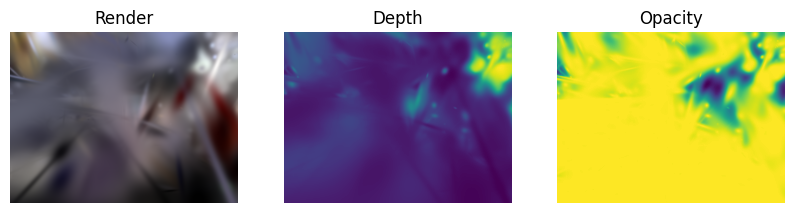

In [9]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(131)
ax1.imshow(render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy())
ax1.set_title("Render")
ax1.set_axis_off()

ax2 = fig.add_subplot(132)
ax2.imshow(render_pkg["depth"].permute(1, 2, 0).detach().cpu().numpy())
ax2.set_title("Depth")
ax2.set_axis_off()

ax3 = fig.add_subplot(133)
ax3.imshow(render_pkg["opacity"].permute(1, 2, 0).detach().cpu().numpy())
ax3.set_title("Opacity")
ax3.set_axis_off()

In [22]:
h, w = render_pkg["render"].shape[1:]
n = render_pkg["n_touched"].shape[0]
n/(h*w)

480 640


0.118544921875